In [81]:
import os
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve
from scipy.ndimage import generate_binary_structure, label
from scipy.ndimage import sum as ndimage_sum

from astropy.io import fits
from astropy.table import Table
from astropy.table import vstack
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std, SigmaClip
from astropy.nddata import NDData

from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry, ApertureStats, CircularAperture, CircularAnnulus
from photutils.background import Background2D, MedianBackground
from photutils.psf import PSFPhotometry, SourceGrouper, CircularGaussianPRF, IntegratedGaussianPRF, fit_fwhm, EPSFBuilder
from photutils.psf import extract_stars

import photutils
print(photutils.__version__)
print(photutils.__file__)

#f_name = "./ref_FS001_121011_1_J.fits"
#f_name = "./ref_FS014_151219_1_J.fits"
#f_name = "./ref_FS017_120106_1_J.fits"
f_name = "./zb08c_0826_76526.fits"





2.2.0
/usr/local/lib/python3.11/site-packages/photutils/__init__.py


In [82]:
hdul = fits.open(f_name)
image = hdul[0].data
header = hdul[0].header
hdul.close()


(2048, 2048)


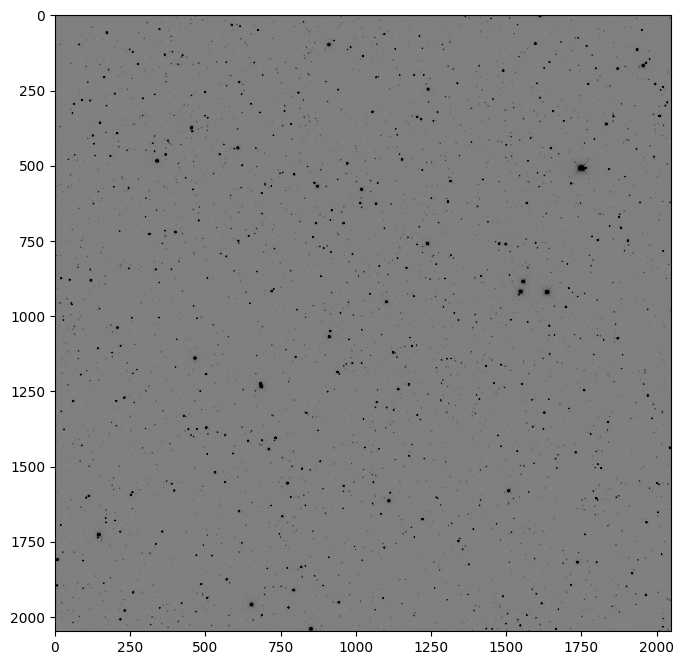

In [83]:

#image = image[:1146,:]

print(image.shape)

vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)

plt.figure(figsize=(8, 8))
plt.imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
plt.show()

In [84]:
def make_segments(image, n_segments=10, overlap=0):
    height, width = image.shape
    seg_h = height // n_segments
    seg_w = width // n_segments

    segments = []
    
    for i in range(n_segments):
        for j in range(n_segments):
            result = {}
            
            y_start = (i * seg_h) - overlap 
            if y_start < 0: y_start = 0
            x_start = (j * seg_w) - overlap 
            if x_start < 0: x_start = 0
            y_end = ((i + 1) * seg_h) + overlap if i < n_segments - 1 else height
            x_end = ((j + 1) * seg_w) + overlap if j < n_segments - 1 else width
            
            subframe = image[y_start:y_end, x_start:x_end]

            result = {}
            result["x"] = [x_start,x_end]
            result["y"] = [y_start,y_end]
            result["subframe"] = subframe
            segments.append(result)

    return segments

[ 3.32279412e+02  1.48570568e-03  5.84367554e-04 -4.54368485e-07
 -2.87974562e-07 -2.97730535e-07]
max amplitude: 1.13
max frame gradient: 1.12


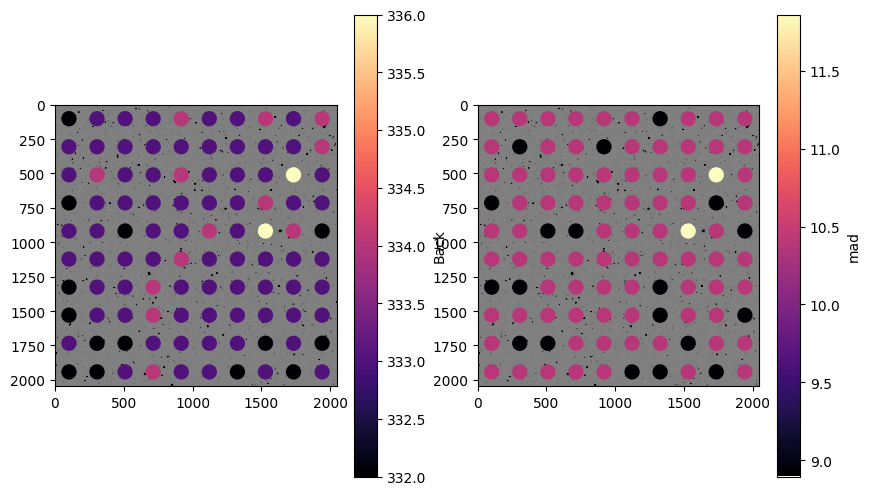

In [85]:
segments = make_segments(image,n_segments=10)

x = []
y = []
back = []
back_mad = []
for s in segments:
    x_tmp = (s["x"][0]+s["x"][1])//2
    y_tmp = (s["y"][0]+s["y"][1])//2
    x.append(x_tmp)
    y.append(y_tmp)
    back.append(np.median(s["subframe"]))
    back_mad.append(mad_std(s["subframe"]))


x = np.array(x)
y = np.array(y)
back = np.array(back)

A = np.vstack([np.ones_like(x),x, y,x**2, x*y, y**2]).T
coeff, *_ = np.linalg.lstsq(A, back, rcond=None)
 

def polysurf(x, y, coeff):
    a0, a1, a2, a3, a4, a5 = coeff
    return a0 + a1*x + a2*y + a3*x**2 + a4*x*y + a5*y**2

x0 = min(x)
y0 = min(y)
xk = max(x)
yk = max(y)

le = []
re = []
ue = []
de = []

bk = []

for xi,yi in zip(x,y):
    bk.append(polysurf(xi,yi,coeff))
    le.append(polysurf(x0,yi,coeff))
    re.append(polysurf(xk,yi,coeff))
    ue.append(polysurf(xi,yk,coeff))
    de.append(polysurf(xi,y0,coeff))
    

max_amplitude = max(bk) - min(bk)
max(le)-min(re)
frame_gradient = max(max((max(le)-min(re)),(max(re)-min(le))),max((max(ue)-min(de)),(max(de)-min(ue))))


print(coeff)
# makymalna amplituda oraz maksymalny gradient w osiach x lub y (ale moze byc po skosie)
print(f"max amplitude: {max_amplitude:.2f}")
print(f"max frame gradient: {frame_gradient:.2f}")



vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)



fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
sct1 = ax[0].scatter(x,y,c=back, cmap='magma', s=100)

ax[1].imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
sct2 = ax[1].scatter(x,y,c=back_mad, cmap='magma', s=100)

plt.colorbar(sct1, ax=ax[0], label='Back')
plt.colorbar(sct2, ax=ax[1], label='mad')

plt.show()


In [86]:
segments = make_segments(image,n_segments=10,overlap=5)

sources = Table
all_sources = []

x = []
y = []
for s in segments:
    x_tmp = (s["x"][0]+s["x"][1])//2
    y_tmp = (s["y"][0]+s["y"][1])//2
    x.append(x_tmp)
    y.append(y_tmp)

    data = s["subframe"]
    daofind = DAOStarFinder(fwhm=4., threshold=5.*mad_std(data),sharplo=0.0)  
    sources_tmp = daofind(data-np.median(data))
    #print(mad_std(data))

    if sources_tmp is not None and len(sources_tmp) > 0:
        # Dodaj przesunięcie do centroidów
        sources_tmp['xcentroid'] = sources_tmp['xcentroid'] + s["x"][0]
        sources_tmp['ycentroid'] = sources_tmp['ycentroid'] + s["y"][0]
        all_sources.append(sources_tmp)

# Połącz wszystkie tabele
if all_sources:
    sources = vstack(all_sources)
else:
    sources = None 

sources.sort('mag')

#daofind = DAOStarFinder(fwhm=4.0, threshold=5.*mad_std(image))  
#sources = daofind(image)

print('przed usuwaniem powtrorzen', len(sources))
repeted = []
for i,s in enumerate(sources):
    x,y = s['xcentroid'],s['ycentroid']
    r = (x-sources['xcentroid'])**2 + (y-sources['ycentroid'])**2
    i_min = np.argmin(r)
    if i != i_min:
        if r[i_min] < 1.0:
            repeted.append(i_min)
mask = np.ones(len(sources), dtype=bool)
mask[repeted] = False
sources = sources[mask]
print('z usuwanietymi powtrorzeniami', len(sources))

sources['id'] = np.arange(1, len(sources)+1)

print(sources.keys())
print(sources)

przed usuwaniem powtrorzen 6313
z usuwanietymi powtrorzeniami 6005
['id', 'xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'roundness2', 'npix', 'peak', 'flux', 'mag', 'daofind_mag']
 id      xcentroid      ...         mag              daofind_mag     
---- ------------------ ... ------------------- ---------------------
   1 1634.8803846922046 ... -15.103114474551607    -7.458849860387119
   2  1634.610510521513 ...  -15.02267281707959    -7.750447268250722
   3 1748.1698134130845 ...  -15.00408444744053    -7.158849376009579
   4 144.82407456510057 ... -14.910021737219612   -7.9736727109668095
   5  652.9776947769898 ...  -14.84008863420546    -8.080900740839787
   6  1555.882083714712 ... -14.779748180720059     -7.89226809526686
   7  684.9914549138432 ... -14.777540933652416    -8.129856729822261
 ...                ... ...                 ...                   ...
5998 1852.9471575788461 ...                -0.0 -0.028010955154407935
5999  1051.803599494355 ...                

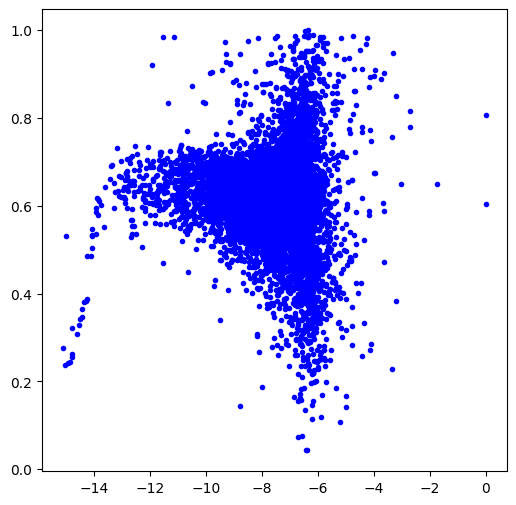

In [87]:
x = sources["mag"]
#y = sources["roundness2"]
y = sources["sharpness"]

maska = y > 0.75

plt.figure(figsize=(6, 6))
plt.plot(x, y, '.b')
plt.show()

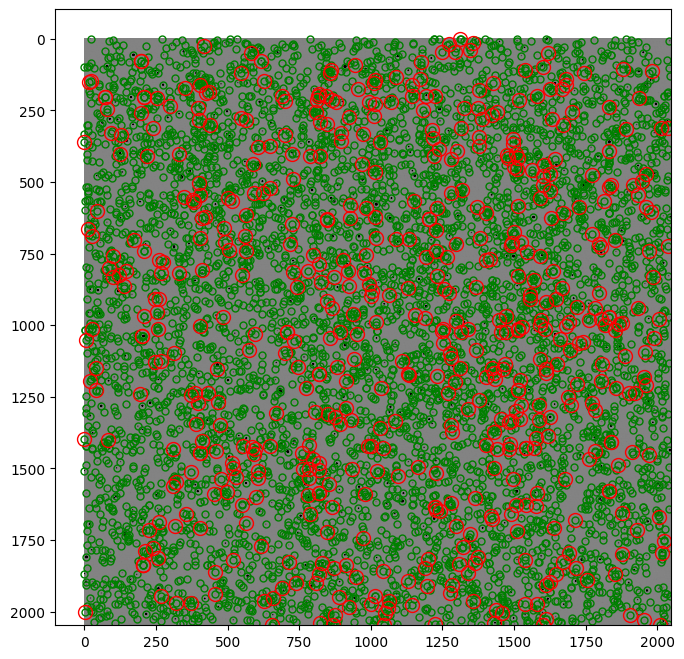

In [88]:

x = sources["xcentroid"].data-1
y = sources["ycentroid"].data-1

co = sources["sharpness"]

vmin = np.mean(image) - 1 * np.std(image)
vmax = np.mean(image) + 1 * np.std(image)

plt.figure(figsize=(8, 8))
plt.imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
plt.plot(x, y, 'o', markerfacecolor='none', markeredgecolor='green', markersize=5)

plt.plot(x[maska], y[maska], 'o', markerfacecolor='none', markeredgecolor='red', markersize=10)
#sct = plt.scatter(x, y, c=co, cmap='viridis', facecolors='none', s=50)
#plt.colorbar(sct)
plt.show()

In [89]:
ron = 5   # e
gain = 1  #  e/adu

ap = Table()
ap["id"] = sources["id"]
ap["xcentroid"] = sources["xcentroid"]
ap["ycentroid"] = sources["ycentroid"]

xy_pos = list(zip(sources['xcentroid'], sources['ycentroid']))

annulus_aperture = CircularAnnulus(xy_pos, r_in=15, r_out=20)
sigclip = SigmaClip(sigma=3.0, maxiters=5)
bkg_stats = ApertureStats(image, annulus_aperture, sigma_clip=sigclip)
local_bkg = bkg_stats.median
bkg_mad = bkg_stats.mad_std
mk_bkg = annulus_aperture.to_mask(method='center')

radii = [3,5,7,10]
apertures = [CircularAperture(xy_pos, r=r) for r in radii]

for r,aper in zip(radii,apertures):
    tmp = ApertureStats(image, aper, sigma_clip=None)
    adu = np.array(tmp.sum) - np.array(local_bkg * tmp.sum_aper_area)
    ap[f"aperture_sum_{r}"] = adu
    mag = 25 - 2.5 * np.log10(adu)
    ap[f"mag_{r}"] = mag

    err_ron = np.array(tmp.sum_aper_area) * ron**2
    err_bkg = np.array(tmp.sum_aper_area) * bkg_mad**2
    err_star = adu/gain

    noise = (err_ron + err_bkg + err_star)**0.5
    sn = adu/noise

    err = 1.0857 * (noise / adu)

    ap[f"err_{r}"] = err
    ap[f"sn_{r}"] = sn

print(ap.keys())

print(ap)

#stat_aper = CircularAperture(xy_pos, r=7)
#aperstats = ApertureStats(image, stat_aper, sigma_clip=None)

#print("fwhm = ",np.nanmedian(aperstats.fwhm[:10]))

#radii = [3, 5, 7]  # piksele
#apertures = [CircularAperture(xy_pos, r=r) for r in radii]

#phot_table1 = aperture_photometry(image, apertures, method='subpixel', subpixels=10)
#phot_table2 = aperture_photometry(image, apertures)

#print(phot_table1.keys())

#tmp = (phot_table2["aperture_sum_0"])
#print(tmp)


/var/folders/d1/n39w6bbs3f1_3tml2k1fftww0000gn/T/ipykernel_725/3827047507.py:25: RuntimeWarning: invalid value encountered in log10
  mag = 25 - 2.5 * np.log10(adu)


['id', 'xcentroid', 'ycentroid', 'aperture_sum_3', 'mag_3', 'err_3', 'sn_3', 'aperture_sum_5', 'mag_5', 'err_5', 'sn_5', 'aperture_sum_7', 'mag_7', 'err_7', 'sn_7', 'aperture_sum_10', 'mag_10', 'err_10', 'sn_10']
 id      xcentroid      ...         err_10               sn_10        
---- ------------------ ... --------------------- --------------------
   1 1634.8803846922046 ... 0.0008216215215255937   1321.4113451946382
   2  1634.610510521513 ... 0.0008217100263767938   1321.2690184483088
   3 1748.1698134130845 ... 0.0005744232930757118   1890.0695934294213
   4 144.82407456510057 ...  0.001050444830342286   1033.5621335260666
   5  652.9776947769898 ...   0.00108360236349427   1001.9357991237357
   6  1555.882083714712 ...  0.001034818165996354   1049.1698306771175
   7  684.9914549138432 ... 0.0009952813485612463   1090.8473283152155
 ...                ... ...                   ...                  ...
5998 1852.9471575788461 ...   -0.4389083088822378  -2.4736373817231634
5999  

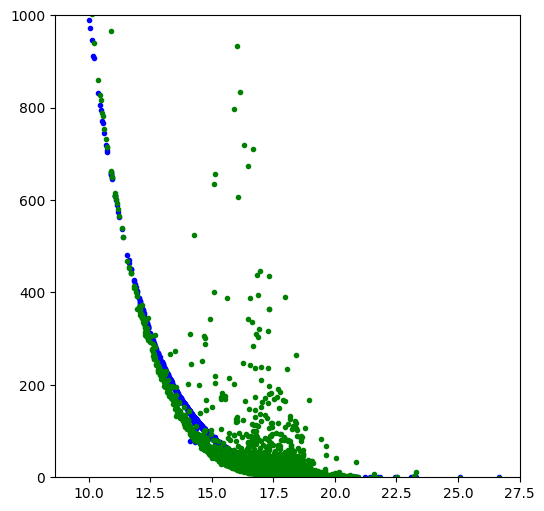

In [92]:
x = ap["mag_3"]
y = ap["sn_3"]


y2 = ap["sn_10"]

maska = x < 18.2

plt.figure(figsize=(6, 6))
plt.plot(x, y, '.b')
plt.plot(x, y2, '.g')
plt.ylim(0,1000)
plt.show()

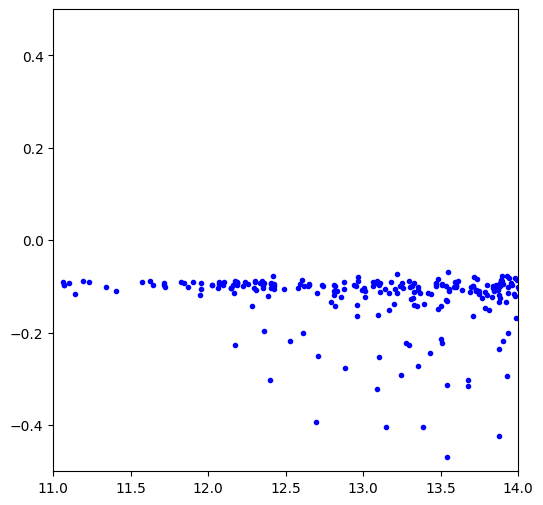

In [108]:
x = ap["mag_3"]
y = ap["mag_10"] - ap["mag_3"]

#maska = x < 18.2

plt.figure(figsize=(6, 6))
plt.plot(x, y, '.b')
plt.ylim(-0.5,0.5)
plt.xlim(11,14)
plt.show()

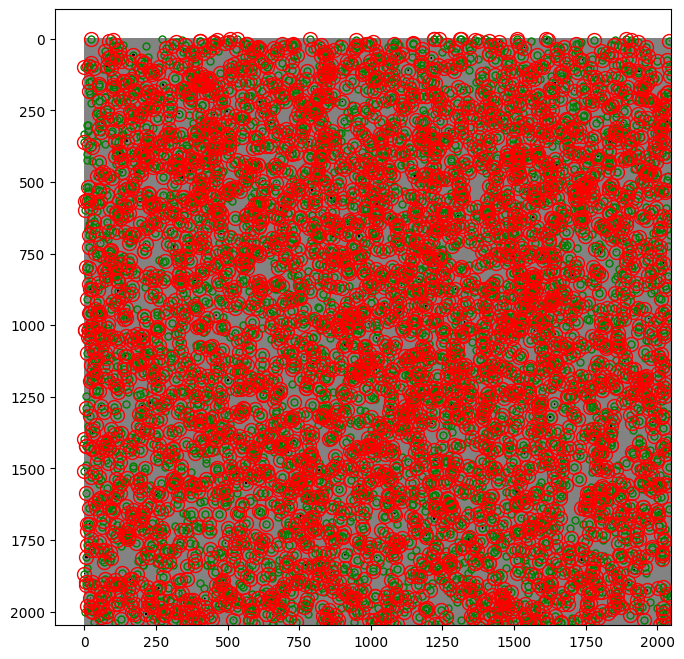

In [109]:
x = sources["xcentroid"].data-1
y = sources["ycentroid"].data-1

vmin = np.mean(image) - 1 * np.std(image)
vmax = np.mean(image) + 1 * np.std(image)

plt.figure(figsize=(8, 8))
plt.imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
plt.plot(x, y, 'o', markerfacecolor='none', markeredgecolor='green', markersize=5)

plt.plot(x[maska], y[maska], 'o', markerfacecolor='none', markeredgecolor='red', markersize=10)
plt.show()

16.308624403561623


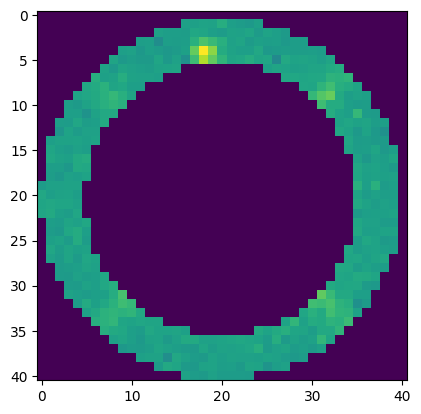

In [110]:
data_weighted = mk_bkg[0].multiply(image)
data_weighted_1d = mk_bkg[0].get_values(image)
print(mad_std(data_weighted_1d))
plt.imshow(data_weighted)

(2048, 2048)


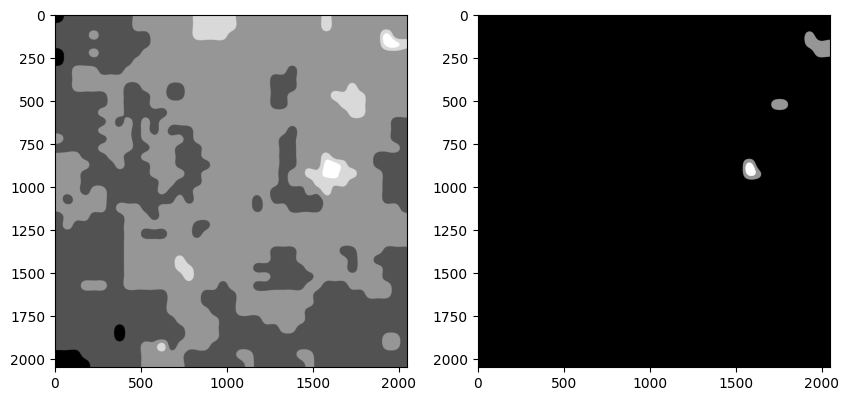

In [116]:
# obliczanie backgroundu

sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(image, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

print(bkg.background.shape)


fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(bkg.background,cmap='Greys_r')
ax[1].imshow(bkg.background_rms,cmap='Greys_r')
plt.show()


In [122]:
import inspect



#print(inspect.getfullargspec(PSFPhotometry.__init__))

from photutils.psf import PSFPhotometry
#print(dir(PSFPhotometry))
#print(help(PSFPhotometry))

333.0
27.0


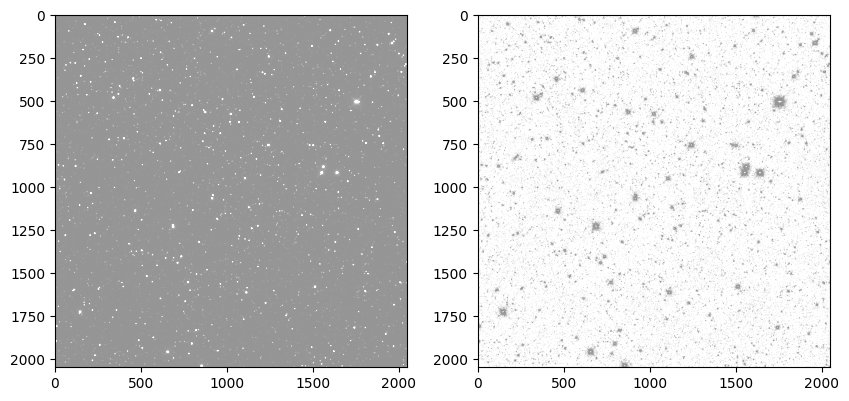

In [123]:
image_tmp = image-bkg.background

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)
ax[0].imshow(image,vmin=vmin,vmax=vmax,cmap='Greys_r')
print(np.median(image))
vmin = np.median(image_tmp)  - 1 * np.std(image_tmp)
vmax = np.median(image_tmp)  + 1 * np.std(image_tmp)
ax[1].imshow(image_tmp,vmin=vmin,vmax=vmax,cmap='Greys_r')
print(np.median(image_tmp))
plt.show()

In [124]:

xypos = list(zip(sources['xcentroid'], sources['ycentroid']))[:5]

fwhm = fit_fwhm(image_tmp, xypos=xypos, fit_shape=(5, 5), fwhm=2)
print(fwhm, np.mean(fwhm))


[4.73014565 4.73276914 6.81637164 3.41707725 3.2150707 ] 4.582286876972867


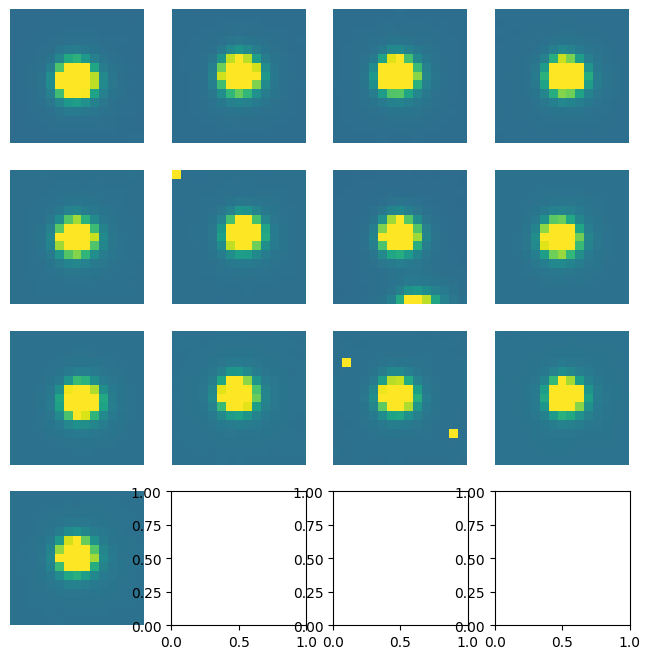

In [125]:

image_nd = NDData(data=image_tmp)
stars_table = Table()
stars_table['x'] = sources['xcentroid'][10:24]
stars_table['y'] = sources['ycentroid'][10:24]

stars = extract_stars(image_nd, stars_table, size=15)  # size - rozmiar wycinka, dopasuj do FWHM
epsf_builder = EPSFBuilder(oversampling=4, maxiters=10, progress_bar=True)


nc = int(np.sqrt(len(stars))) + 1
nr = int(len(stars)/nc + 1)

fig, ax = plt.subplots(nr, nc, figsize=(8, 8))

for i,tmp in enumerate(stars):
    n = int(i/nc) 
    m = int(i%nc)
    #print(n,m)
    vmin = np.mean(tmp) - 1 * np.std(tmp)
    vmax = np.mean(tmp) + 1 * np.std(tmp)
    ax[n][m].imshow(tmp,vmin=vmin,vmax=vmax,cmap='viridis')
    ax[n][m].axis('off')
plt.show()


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

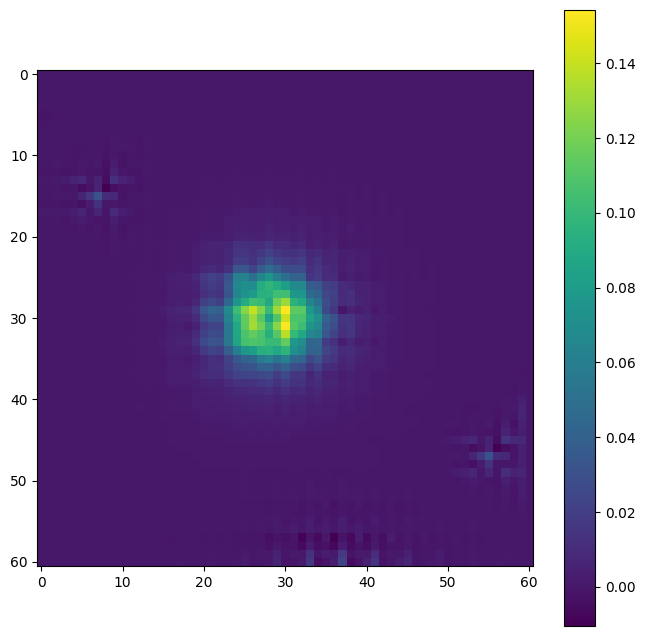

In [126]:



# Budujemy EPSF (uśredniony model PSF)
epsf, fitted_stars = epsf_builder(stars)

# epsf to teraz Twoja dokładna PSF, np. możesz ją zobaczyć

plt.figure(figsize=(8, 8))
plt.imshow(epsf.data, cmap='viridis')
plt.colorbar()
plt.show()


In [68]:

init_params = Table()
init_params['x_init'] = sources['xcentroid']
init_params['y_init'] = sources['ycentroid']
if 'flux' in sources.colnames:
    init_params['flux_init'] = sources['flux']

#psf_model = CircularGaussianPRF(flux=1, fwhm=3.2)
psf_model = epsf
fit_shape = (11, 11)
#finder = DAOStarFinder(threshold=10.0, fwhm=3.0)
group_maker = SourceGrouper(2.0)  # grupowanie gwiazd blisko siebie
#psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder, aperture_radius=4)
psfphot = PSFPhotometry(psf_model, fit_shape, grouper=group_maker, aperture_radius=4)

# Teraz wywołujesz photometrię na obrazie 'image' (np. tablica numpy)
out = psfphot(image_tmp, init_params=init_params)

out_tmp = out[out['flags'] == 0]

out = out_tmp

mag = 25 - 2.5 * np.log10(out['flux_fit'])
out['mag_psf'] = mag

out.sort('mag_psf')


print(out)

 id  group_id group_size ...         cfit         flags      mag_psf      
---- -------- ---------- ... -------------------- ----- ------------------
   5        4          1 ...  0.03654139434110283     0  9.663181994604962
  10        9          1 ...  0.02858951102466837     0  9.689170961491573
   6        5          1 ...  0.04261039968508502     0  9.721940378090732
   3        2          1 ... 0.046089357530791686     0  9.753694247200285
   7        6          1 ... 0.040579095320949124     0   9.75607270580955
   1        1          2 ... 0.037975924434766405     0  9.896885525448361
   2        1          2 ... 0.040896394125514886     0  9.977327182920332
 ...      ...        ... ...                  ...   ...                ...
3521     3290          1 ...   1.0882210856876553     0  20.86677961048193
3522     3291          1 ...   1.6639339895448768     0  20.89124596783568
3525     3294          1 ...   2.0777080844232994     0 21.077763571015375
3523     3292          1 

In [69]:
print(out.keys())

['id', 'group_id', 'group_size', 'local_bkg', 'x_init', 'y_init', 'flux_init', 'x_fit', 'y_fit', 'flux_fit', 'x_err', 'y_err', 'flux_err', 'npixfit', 'qfit', 'cfit', 'flags', 'mag_psf']


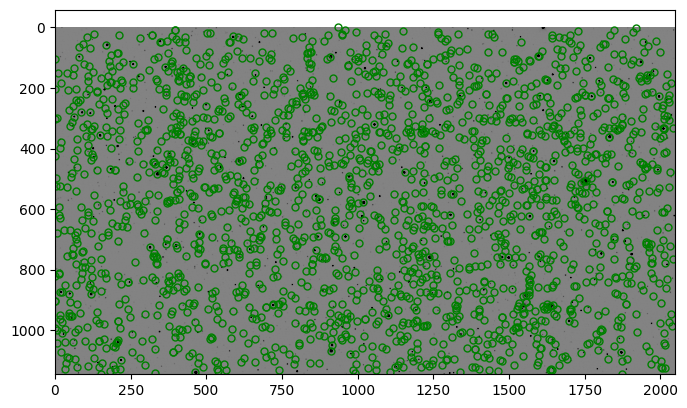

In [70]:
x = out["x_fit"].data-1
y = out["y_fit"].data-1

vmin = np.mean(image) - 1 * np.std(image)
vmax = np.mean(image) + 1 * np.std(image)

plt.figure(figsize=(8, 8))
plt.imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
plt.plot(x, y, 'o', markerfacecolor='none', markeredgecolor='green', markersize=5)
#plt.ylim(0,1200)
#plt.xlim(0,1200)
plt.show()


In [71]:
print(ap.keys())

['id', 'xcentroid', 'ycentroid', 'aperture_sum_3', 'mag_3', 'err_3', 'sn_3', 'aperture_sum_5', 'mag_5', 'err_5', 'sn_5', 'aperture_sum_7', 'mag_7', 'err_7', 'sn_7', 'aperture_sum_10', 'mag_10', 'err_10', 'sn_10']


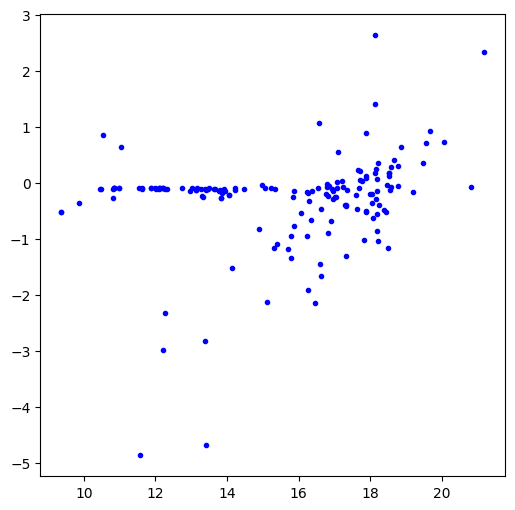

In [72]:
x_psf = []
y_psf = []
mag = []
dif = []

for s in ap:
    x,y = s['xcentroid'],s['ycentroid']
    r = (x-out['x_fit'])**2 + (y-out['y_fit'])**2
    i_min = np.argmin(r)
    if r[i_min] < 1:
        x_psf.append(out['x_fit'][i_min])
        y_psf.append(out['y_fit'][i_min])
        mag.append(s['mag_7'])
        dif.append(s['mag_7'] - out['mag_psf'][i_min])
        #print(r[i_min]**0.5,s['mag_7'],out['mag_psf'][i_min])



plt.figure(figsize=(6, 6))
plt.plot(mag, dif, '.b')

x_psf=np.array(x_psf)
y_psf=np.array(y_psf)

maska = np.array(dif) < -0.5

plt.show()


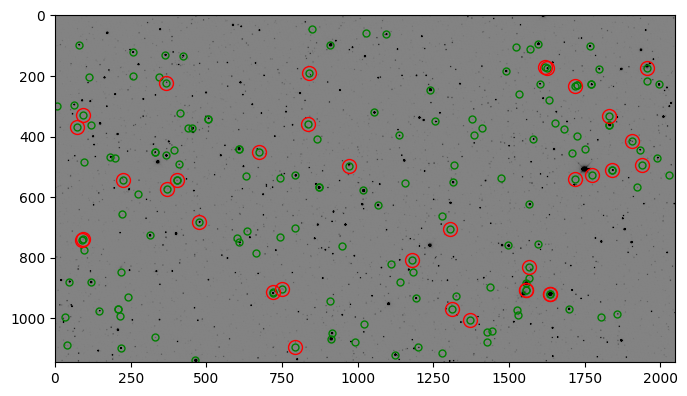

In [73]:
x = x_psf-1
y = y_psf-1

vmin = np.mean(image) - 1 * np.std(image)
vmax = np.mean(image) + 1 * np.std(image)

plt.figure(figsize=(8, 8))
plt.imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
plt.plot(x, y, 'o', markerfacecolor='none', markeredgecolor='green', markersize=5)
plt.plot(x[maska], y[maska], 'o', markerfacecolor='none', markeredgecolor='red', markersize=10)
plt.show()


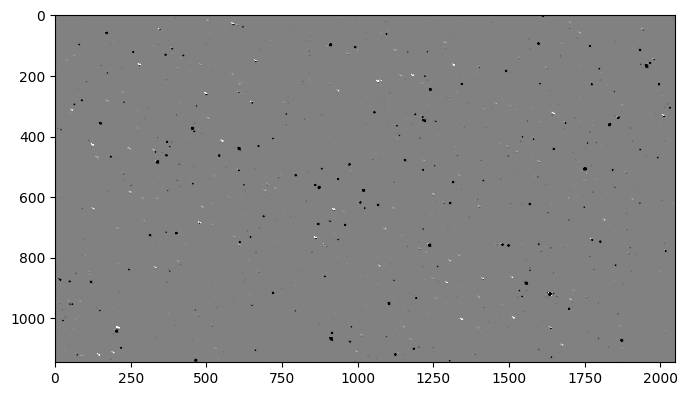

In [74]:
model_image = psfphot.make_model_image(shape=image_tmp.shape, psf_shape=fit_shape)

vmin = np.mean(model_image) - 1 * np.std(model_image)
vmax = np.mean(model_image) + 1 * np.std(model_image)

plt.figure(figsize=(8, 8))
plt.imshow(model_image,vmin=vmin,vmax=vmax,cmap='binary')
plt.show()


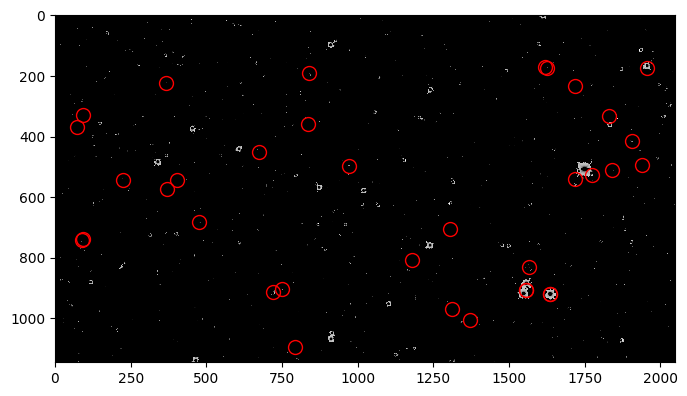

In [75]:

residual = psfphot.make_residual_image(image_tmp,psf_shape=fit_shape)

x = x_psf-1
y = y_psf-1

vmin = np.mean(image) - 1 * np.std(image)
vmax = np.mean(image) + 1 * np.std(image)

plt.figure(figsize=(8, 8))
plt.imshow(residual,vmin=vmin,vmax=vmax,cmap='binary')
#plt.plot(x, y, 'o', markerfacecolor='none', markeredgecolor='green', markersize=5)
plt.plot(x[maska], y[maska], 'o', markerfacecolor='none', markeredgecolor='red', markersize=10)
plt.show()



